# Convolutional Variational Autoencoder Implementation for Reconstruction of CartoonFaces dataset

In this notebook we train a Variational Autoencoder (VAE) on the [CartoonFaces dataset](https://www.kaggle.com/datasets/brendanartley/cartoon-faces-googles-cartoon-set). The VAE is a type of autoencoder probabilistic. So instead of leatting our neural network learn an arbitrary function, we are learning the parameters of a probability distribution modeling our data.

### Import the dataset from Kaggle

In [1]:
import kaggle

In [2]:
!kaggle datasets download -d brendanartley/cartoon-faces-googles-cartoon-set

cartoon-faces-googles-cartoon-set.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import os
from glob import glob
 

DATA_FOLDER = './cartoonset100k_jpg/cartoonset100k_jpg/'


#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('cartoon-faces-googles-cartoon-set.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./cartoonset100k_jpg/')

### Setup

In [4]:
import numpy as np

import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model

In [5]:
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 100000


### Generate batch

Since using the whole dataset would be very computational expensive we are only using a batch of 512 images.

In [28]:
INPUT_DIM = (64,64,3) # Image dimension
BATCH_SIZE = 512
Z_DIM = 128 # Dimension of the latent vector (z)

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

Found 100000 images belonging to 10 classes.


### Define the architecture of our encoder and decoder networks 

In this VAE example, we use two small ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively.  Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation $x$ and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$. 


### Decoder network 
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation $x$. Model the latent distribution prior $p(z)$ as a unit Gaussian.


### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

### Network architecture
For the encoder network, use four convolutional layers followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by five convolution transpose layers (a.k.a. deconvolutional layers in some contexts). 

### Create a sampling layer

In [29]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Build the encoder

In [30]:
latent_dim = Z_DIM

encoder_inputs = keras.Input(shape=INPUT_DIM)


x = layers.Conv2D(32, 3, strides=1, padding="same")(encoder_inputs)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(32, 3, strides=1, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(64, 3, strides=1, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(256, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Flatten()(x)

x = layers.Dropout(0.40)(x)

x = layers.Dense(2048)(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="Encoder")
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_14 (Conv2D)             (None, 64, 64, 32)   896         ['input_5[0][0]']                
                                                                                                  
 leaky_re_lu_34 (LeakyReLU)     (None, 64, 64, 32)   0           ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_15 (Conv2D)             (None, 64, 64, 32)   9248        ['leaky_re_lu_34[0][0]']         
                                                                                            

### Build the decoder

In [31]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(2048)(latent_inputs)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Dense(4*4*256)(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Reshape((4,4,256))(x)

x = layers.Conv2DTranspose(256, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64, 3, strides=1, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(32, 3, strides=1, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(32, 3, strides=1, padding="same")(x)
#x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)


decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="Decoder")
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_7 (Dense)             (None, 2048)              264192    
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 4096)              8392704   
                                                                 
 leaky_re_lu_43 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 8, 8, 256)        5900

### Define the VAE as a `Model` with a custom `train_step`

In [32]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss           
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Train the VAE

In [33]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(1e-3))
history = vae.fit(data_flow[0][0], epochs=300, batch_size=128)

Epoch 1/300
4/4 [==============================] - 2s 85ms/step - loss: 2816.7260 - reconstruction_loss: 2792.0791 - kl_loss: 0.1049
Epoch 2/300
4/4 [==============================] - 0s 87ms/step - loss: 2369.3459 - reconstruction_loss: 2203.8286 - kl_loss: 77.7719
Epoch 3/300
4/4 [==============================] - 0s 85ms/step - loss: 1778.8016 - reconstruction_loss: 1629.2247 - kl_loss: 0.1952
Epoch 4/300
4/4 [==============================] - 0s 85ms/step - loss: 1221.4545 - reconstruction_loss: 1269.3936 - kl_loss: 0.1632
Epoch 5/300
4/4 [==============================] - 0s 87ms/step - loss: 1103.0418 - reconstruction_loss: 1079.6311 - kl_loss: 0.0315
Epoch 6/300
4/4 [==============================] - 0s 85ms/step - loss: 1079.1281 - reconstruction_loss: 1066.4478 - kl_loss: 0.0092
Epoch 7/300
4/4 [==============================] - 0s 86ms/step - loss: 988.9034 - reconstruction_loss: 987.5974 - kl_loss: 0.0365
Epoch 8/300
4/4 [==============================] - 0s 84ms/step - loss

4/4 [==============================] - 0s 84ms/step - loss: 611.1354 - reconstruction_loss: 597.0326 - kl_loss: 16.5788
Epoch 124/300
4/4 [==============================] - 0s 87ms/step - loss: 611.8100 - reconstruction_loss: 595.0155 - kl_loss: 17.4231
Epoch 125/300
4/4 [==============================] - 0s 86ms/step - loss: 610.7275 - reconstruction_loss: 594.0873 - kl_loss: 17.1328
Epoch 126/300
4/4 [==============================] - 0s 84ms/step - loss: 611.8299 - reconstruction_loss: 593.9451 - kl_loss: 17.0345
Epoch 127/300
4/4 [==============================] - 0s 86ms/step - loss: 617.4707 - reconstruction_loss: 595.0093 - kl_loss: 17.2217
Epoch 128/300
4/4 [==============================] - 0s 85ms/step - loss: 620.8801 - reconstruction_loss: 594.9825 - kl_loss: 16.8713
Epoch 129/300
4/4 [==============================] - 0s 84ms/step - loss: 615.8945 - reconstruction_loss: 596.1579 - kl_loss: 17.0787
Epoch 130/300
4/4 [==============================] - 0s 84ms/step - loss: 61

4/4 [==============================] - 0s 84ms/step - loss: 568.2218 - reconstruction_loss: 546.9595 - kl_loss: 18.3685
Epoch 246/300
4/4 [==============================] - 0s 84ms/step - loss: 565.4250 - reconstruction_loss: 545.9501 - kl_loss: 17.8450
Epoch 247/300
4/4 [==============================] - 0s 84ms/step - loss: 560.5913 - reconstruction_loss: 546.0734 - kl_loss: 17.8395
Epoch 248/300
4/4 [==============================] - 0s 83ms/step - loss: 571.0788 - reconstruction_loss: 546.3788 - kl_loss: 18.1027
Epoch 249/300
4/4 [==============================] - 0s 85ms/step - loss: 563.1656 - reconstruction_loss: 546.5148 - kl_loss: 17.9630
Epoch 250/300
4/4 [==============================] - 0s 84ms/step - loss: 561.2271 - reconstruction_loss: 546.2388 - kl_loss: 17.8010
Epoch 251/300
4/4 [==============================] - 0s 85ms/step - loss: 563.3455 - reconstruction_loss: 544.7952 - kl_loss: 17.7246
Epoch 252/300
4/4 [==============================] - 0s 85ms/step - loss: 56

### Plot learning curve (Loss vs Epochs)

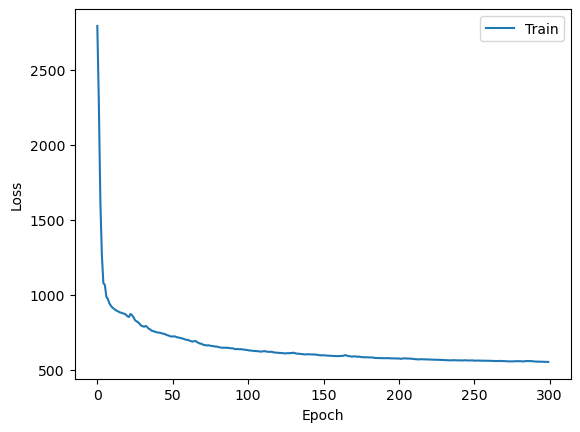

In [34]:
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

### Use CVAE model to predict train images

In [35]:
z_mean, z_log_var, z =  vae.encoder.predict(data_flow[0][0])
reconstruction = vae.decoder.predict(z)

16/16 [==============================] - 0s 14ms/step


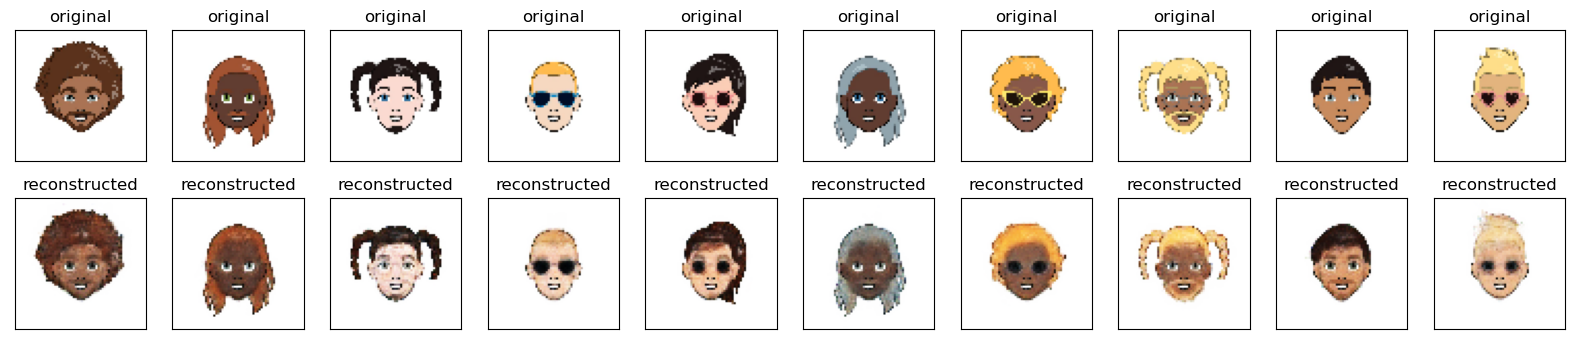

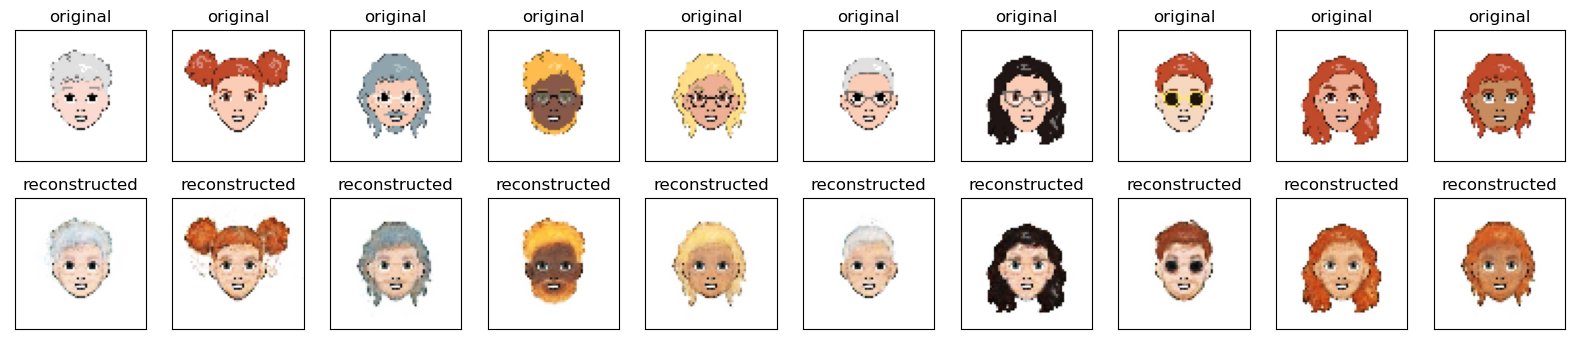

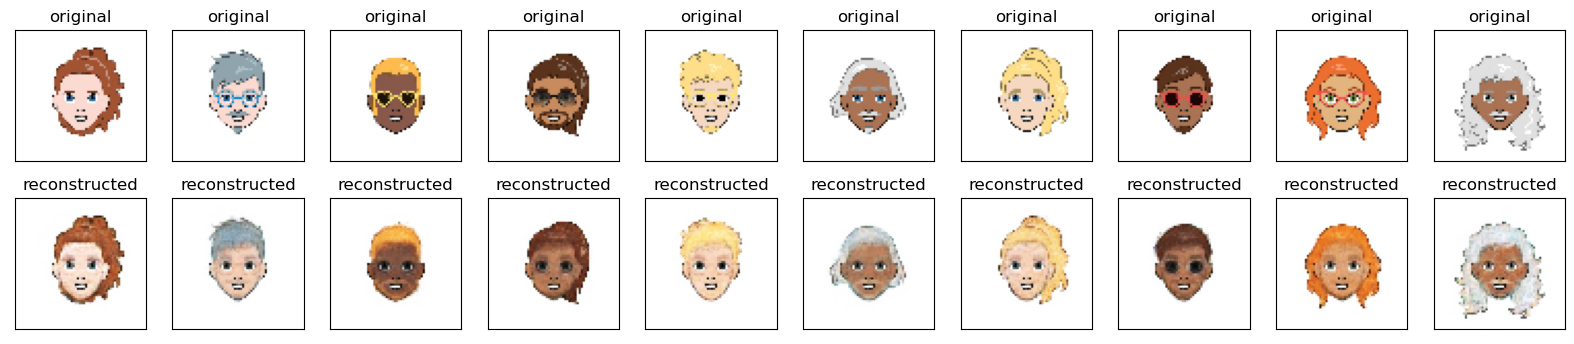

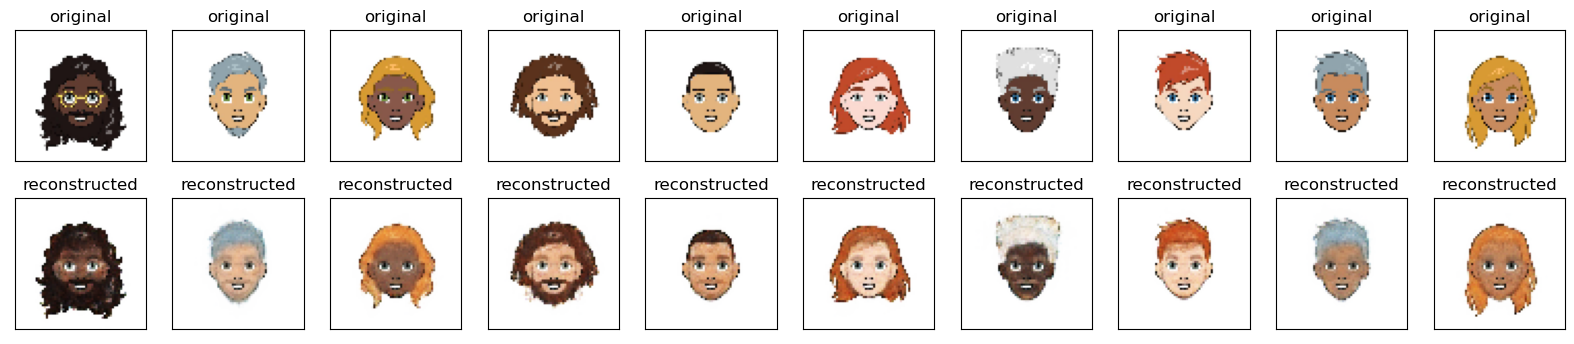

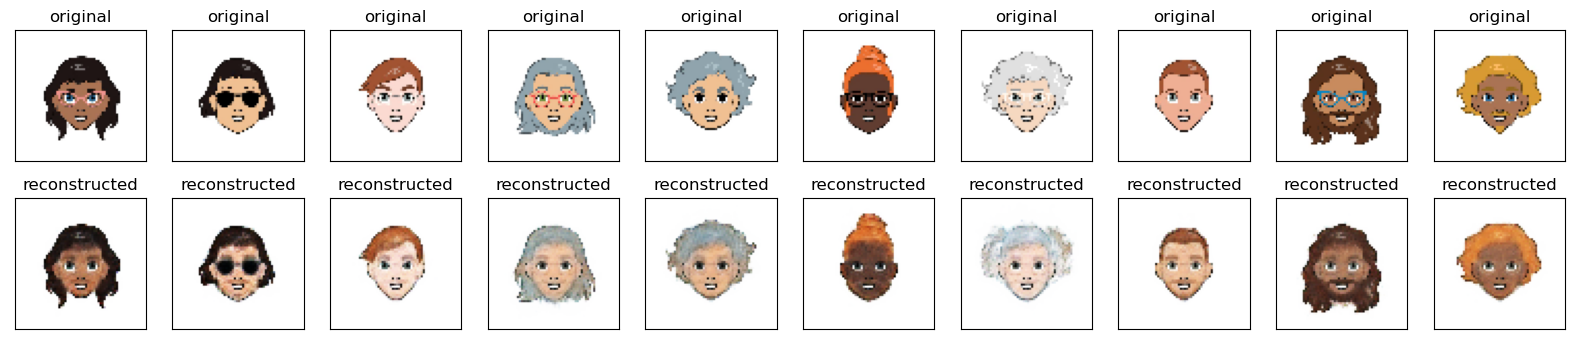

In [36]:
n = 10

for j in range(5):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data_flow[0][0][i+j*10, :, :, :])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstruction[i+j*10, :, :,:])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

### Use CVAE model to predict test images

In [37]:
z_mean, z_log_var, z =  vae.encoder.predict(data_flow[1][0])
reconstruction = vae.decoder.predict(z)

16/16 [==============================] - 0s 10ms/step


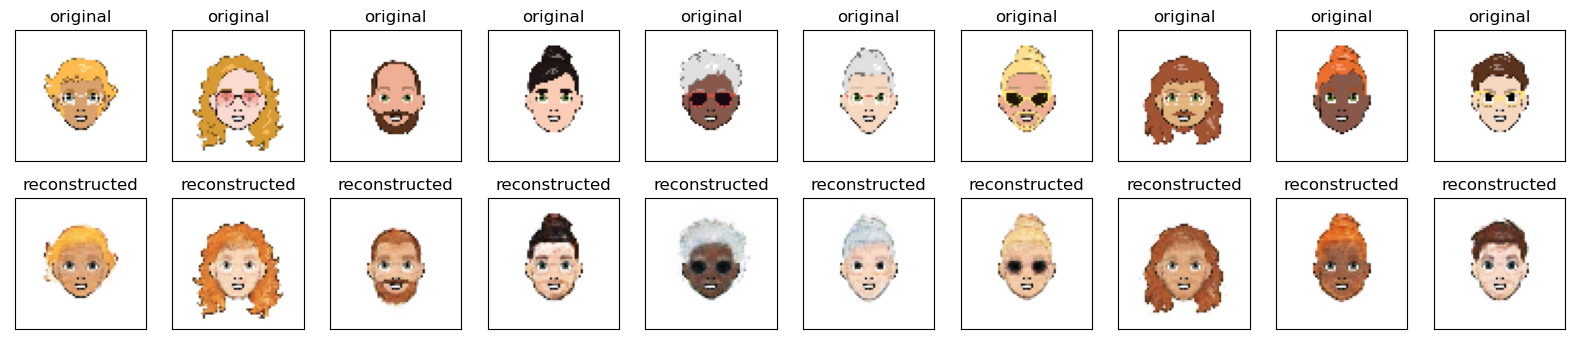

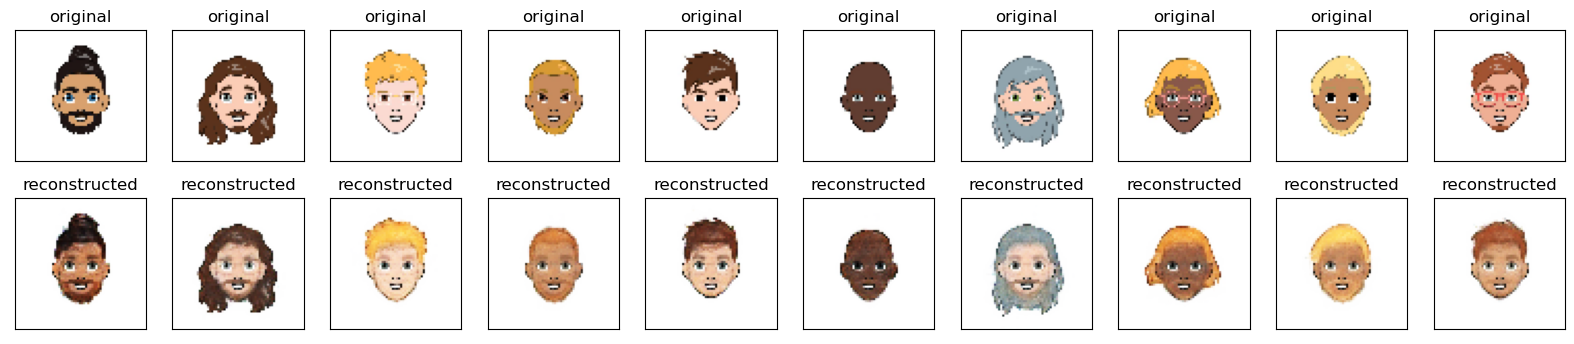

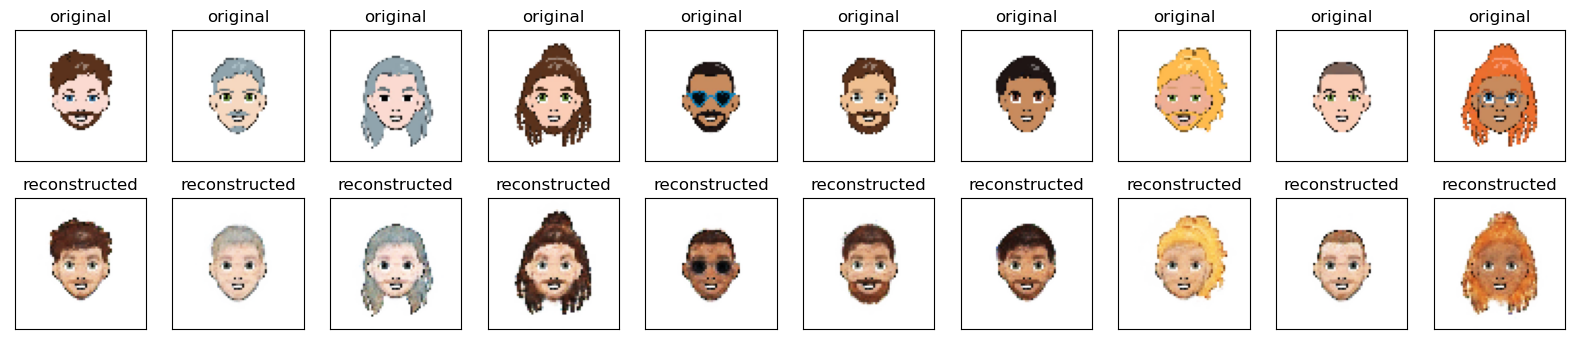

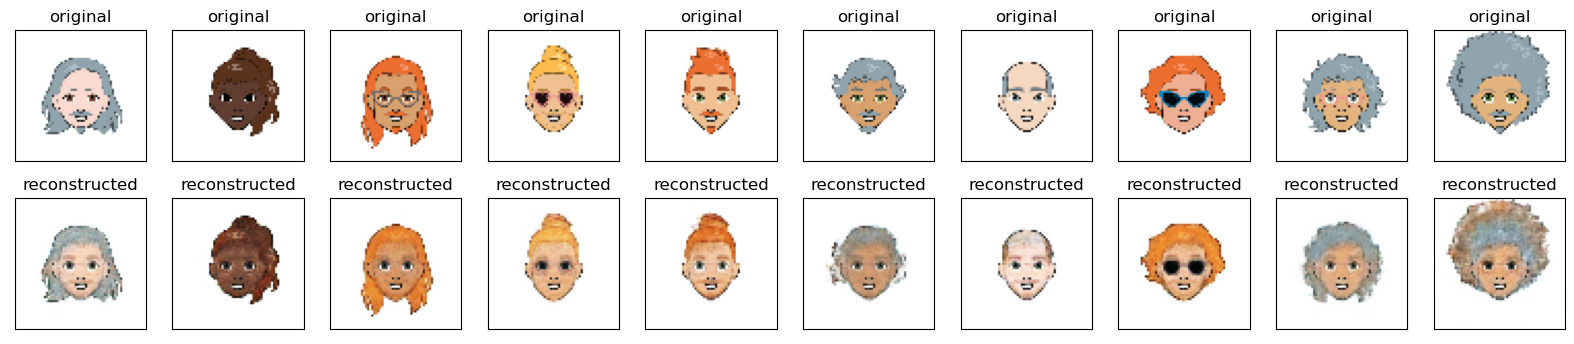

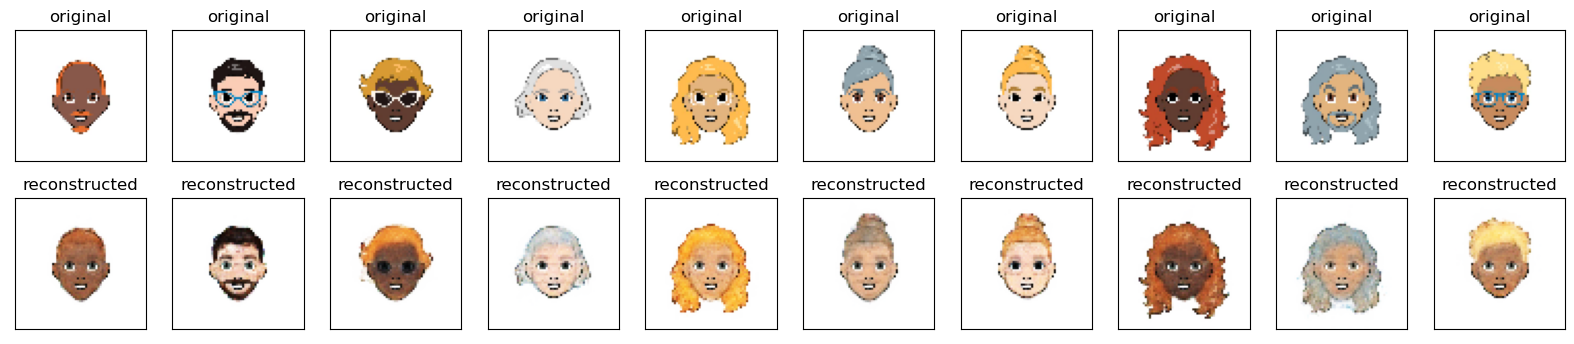

In [38]:
n = 10

for j in range(5):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data_flow[1][0][i+j*10, :, :, :])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstruction[i+j*10, :, :,:])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()